Read from dataset. (e.g. QIN-Breast)

In [1]:
!pip install numpy matplotlib pydicom SimpleITK dicom2nifti scikit-image


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\WANGZ\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [1]:
import os
import pydicom
from pathlib import Path
import SimpleITK as sitk

def load_dicom_files(data_dir):
    """
    读取DICOM文件并组织为嵌套字典格式。
    :param data_dir: 数据根目录
    :return: 数据结构字典
    """
    data_structure = {}
    
    for patient_folder in Path(data_dir).iterdir():
        if not patient_folder.is_dir():
            continue
        patient_id = patient_folder.name
        data_structure[patient_id] = {}
        
        for scan_date_folder in patient_folder.iterdir():
            if not scan_date_folder.is_dir():
                continue
            scan_date = scan_date_folder.name
            data_structure[patient_id][scan_date] = {}
            
            for scan_type_folder in scan_date_folder.iterdir():
                if not scan_type_folder.is_dir():
                    continue
                scan_type = scan_type_folder.name
                data_structure[patient_id][scan_date][scan_type] = {}
                
                for sub_type_folder in scan_type_folder.iterdir():
                    if not sub_type_folder.is_dir():
                        continue
                    sub_type = sub_type_folder.name
                    dicom_files = list(sub_type_folder.glob("*.dcm"))
                    data_structure[patient_id][scan_date][scan_type][sub_type] = dicom_files
    return data_structure


def load_dicom_image(file_list):
    """
    加载DICOM序列为3D图像
    :param file_list: DICOM文件列表
    :return: SimpleITK图像对象
    """
    reader = sitk.ImageSeriesReader()
    reader.SetFileNames([str(f) for f in file_list])
    image = reader.Execute()
    return image


# 使用
data_dir = "../datasets/PyDownloader/QIN-BREAST/" 
data_structure = load_dicom_files(data_dir)

# 示例: 访问特定病人的某个子类型数据
patient_id = "QIN-BREAST-01-0050"
scan_date = "10-05-1990-17578"
scan_type = "MR"
sub_type = "DWIEPIMPS3Tb"

dicom_files = data_structure[patient_id][scan_date][scan_type][sub_type]
if dicom_files:
    image = load_dicom_image(dicom_files)
    print(f"Loaded image with size: {image.GetSize()}")


Loaded image with size: (144, 144, 60)


View dcm

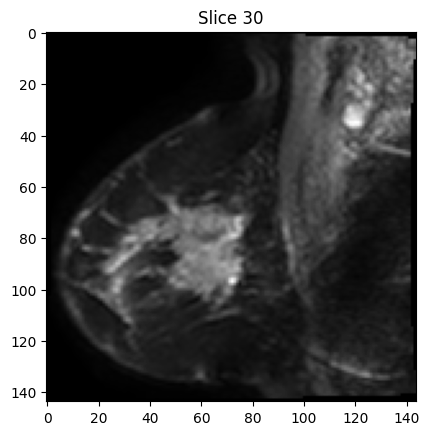

In [2]:
import matplotlib.pyplot as plt

def visualize_image(image):
    """
    可视化3D图像的中心切片
    :param image: SimpleITK图像对象
    """
    size = image.GetSize()
    center_slice = size[2] // 2
    array = sitk.GetArrayFromImage(image)
    plt.imshow(array[center_slice, :, :], cmap="gray")
    plt.title(f"Slice {center_slice}")
    plt.show()

visualize_image(image)


In [11]:
from torch.nn import Sequential, Conv3d, MaxPool3d, Flatten, Linear, ReLU

class Simple3DCNN(nn.Module):
    def __init__(self):
        super(Simple3DCNN, self).__init__()
        self.network = Sequential(
            Conv3d(1, 16, kernel_size=3, stride=1, padding=1),
            ReLU(),
            MaxPool3d(kernel_size=2, stride=2),
            Conv3d(16, 32, kernel_size=3, stride=1, padding=1),
            ReLU(),
            MaxPool3d(kernel_size=2, stride=2),
            Flatten(),
            Linear(32 * 16 * 16 * 16, 128),
            ReLU(),
            Linear(128, 2)
        )

    def forward(self, x):
        return self.network(x)

model = Simple3DCNN().to("cuda")


Epoch 1/20, Loss: 0.7954788712822661
Model saved with loss 0.7954788712822661
Epoch 2/20, Loss: 0.6286751056204036
Model saved with loss 0.6286751056204036
Epoch 3/20, Loss: 0.6360930429429424
Epoch 4/20, Loss: 0.6268911790482852
Model saved with loss 0.6268911790482852
Epoch 5/20, Loss: 0.672587585692503
Epoch 6/20, Loss: 0.6376516229035903
Epoch 7/20, Loss: 0.6362142167529281
Epoch 8/20, Loss: 0.6354452438500463
Epoch 9/20, Loss: 0.6346963808244589
Epoch 10/20, Loss: 0.6391827585745831
Epoch 11/20, Loss: 0.6250773291198575
Model saved with loss 0.6250773291198575
Epoch 12/20, Loss: 0.6430235553760918
Epoch 13/20, Loss: 0.6284741303142236
Epoch 14/20, Loss: 0.6202710045843708
Model saved with loss 0.6202710045843708
Epoch 15/20, Loss: 0.6242373993202132
Epoch 16/20, Loss: 0.6204801554582557
Epoch 17/20, Loss: 0.621988581759589
Epoch 18/20, Loss: 0.6307644546031952
Epoch 19/20, Loss: 0.6334353612393749
Epoch 20/20, Loss: 0.6217943375207939


In [11]:
import os
import pandas as pd

def generate_sample_list(data_dir, label_csv, output_csv):
    """
    扫描 data_dir 下所有病人文件夹 (QIN-BREAST-01-xxxx)，
    并对子文件夹（会话）中可用的 CT / PET / MR 路径进行记录，
    同时细分 MR 文件夹到: DWI, T1, dynamic (基于名称匹配).

    最终输出 CSV 包含列:
      - patient_id
      - session_id
      - ct_path
      - pet_path
      - mr_dwi  (匹配DWI关键字的子文件夹列表, ';'分隔)
      - mr_t1   (匹配T1关键字的子文件夹列表, ';'分隔)
      - mr_dynamic (匹配dynamic关键字的子文件夹列表, ';'分隔)
      - label
    """

    # 1) 读取 label.csv (已经解决好分隔符问题)
    df_label = pd.read_csv(label_csv, sep=',', skiprows=0, header=0)
    df_label.columns = ["PatientID", "Label"]
    # 假设读取后包含列 ["PatientID", "Label"]
    label_dict = dict(zip(df_label["PatientID"], df_label["Label"]))

    rows = []
    # 2) 遍历 data_dir 下的所有病人文件夹
    for patient_id in os.listdir(data_dir):
        patient_folder = os.path.join(data_dir, patient_id)
        if not os.path.isdir(patient_folder):
            continue

        # 查看该 patient_id 是否在 label_dict 中
        if patient_id not in label_dict:
            print(f"[Warning] {patient_id} not found in label.csv, skip.")
            continue

        patient_label = label_dict[patient_id]

        # 3) 遍历该病人的所有会话文件夹
        for session_id in os.listdir(patient_folder):
            session_path = os.path.join(patient_folder, session_id)
            if not os.path.isdir(session_path):
                continue

            # 4) 检查 CT, PT 路径 (跟之前一样)
            ct_path = None
            pet_path = None

            possible_ct_path = os.path.join(session_path, "CT", "CTAC")
            if os.path.isdir(possible_ct_path):
                ct_path = possible_ct_path

            possible_pet_path = os.path.join(session_path, "PT", "PET")
            if os.path.isdir(possible_pet_path):
                pet_path = possible_pet_path

            # 5) 细分 MR 下的子文件夹
            mr_dwi_folders = []
            mr_t1_folders = []
            mr_dynamic_folders = []

            mr_root = os.path.join(session_path, "MR")
            if os.path.isdir(mr_root):
                # 遍历 MR 里的所有子文件夹
                for subf in os.listdir(mr_root):
                    subf_path = os.path.join(mr_root, subf)
                    if not os.path.isdir(subf_path):
                        continue

                    # 将名称转小写以方便匹配
                    subf_lower = subf.lower()

                    if "dwi" in subf_lower:
                        mr_dwi_folders.append(subf_path)
                    elif "t1" in subf_lower:
                        mr_t1_folders.append(subf_path)
                    elif "dynamic" in subf_lower:
                        mr_dynamic_folders.append(subf_path)
                    else:
                        # 如果还想细分更多类别，也可以加判断
                        pass

            # 用分号分隔存储
            mr_dwi_str = ";".join(mr_dwi_folders)
            mr_t1_str = ";".join(mr_t1_folders)
            mr_dynamic_str = ";".join(mr_dynamic_folders)

            row = {
                "patient_id": patient_id,
                "session_id": session_id,
                "ct_path": ct_path if ct_path else "",
                "pet_path": pet_path if pet_path else "",
                "mr_dwi": mr_dwi_str,
                "mr_t1": mr_t1_str,
                "mr_dynamic": mr_dynamic_str,
                "label": patient_label
            }
            rows.append(row)

    df_samples = pd.DataFrame(rows)
    df_samples.to_csv(output_csv, index=False)
    print(f"Sample list saved to {output_csv}")

if __name__ == "__main__":
    data_dir = "../datasets/PyDownloader/QIN-BREAST"          # 数据集根目录
    label_csv = "./QIN_labels.csv"         # 您的标签CSV
    output_csv = "./sample_list.csv"  # 输出
    generate_sample_list(data_dir, label_csv, output_csv)


[Warning] QIN-BREAST-01-0060 not found in label.csv, skip.
[Warning] QIN-BREAST-01-0061 not found in label.csv, skip.
[Warning] QIN-BREAST-01-0062 not found in label.csv, skip.
[Warning] QIN-BREAST-01-0063 not found in label.csv, skip.
[Warning] QIN-BREAST-01-0064 not found in label.csv, skip.
[Warning] QIN-BREAST-01-0065 not found in label.csv, skip.
[Warning] QIN-BREAST-01-0066 not found in label.csv, skip.
[Warning] QIN-BREAST-01-0067 not found in label.csv, skip.
Sample list saved to ./sample_list.csv


In [ ]:
import os
import pandas as pd
import numpy as np
import SimpleITK as sitk
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# =============== #
# 1. 数据读取函数 #
# =============== #
def load_dicom_series(folder_path):
    """
    读取DICOM序列文件夹，将其转换为 (D, H, W) 的 numpy array。
    若找不到DICOM文件，抛出异常或返回None。
    """
    if not os.path.isdir(folder_path):
        # 如果这个路径不存在，返回 None
        return None

    reader = sitk.ImageSeriesReader()
    dicom_files = reader.GetGDCMSeriesFileNames(folder_path)
    if len(dicom_files) == 0:
        return None

    reader.SetFileNames(dicom_files)
    image = reader.Execute()  # SimpleITK image
    array = sitk.GetArrayFromImage(image)  # (D, H, W)
    return array

def resample_volume(image_sitk, out_spacing=(1.0,1.0,1.0)):
    """
    可选：若需要做体素级的重采样(resample)，可以用SimpleITK。
    将输入图像 resample 到指定体素间距。
    这里仅演示思路，您可根据需要修改。
    """
    original_spacing = image_sitk.GetSpacing()  # (z, y, x)
    original_size = image_sitk.GetSize()        # (x, y, z)
    
    # 计算新的Size
    out_size = [
        int(np.round(original_size[0]*(original_spacing[0]/out_spacing[0]))),
        int(np.round(original_size[1]*(original_spacing[1]/out_spacing[1]))),
        int(np.round(original_size[2]*(original_spacing[2]/out_spacing[2])))
    ]

    # 定义resample
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(image_sitk.GetDirection())
    resample.SetOutputOrigin(image_sitk.GetOrigin())
    resample.SetInterpolator(sitk.sitkLinear)
    
    image_resampled = resample.Execute(image_sitk)
    array_resampled = sitk.GetArrayFromImage(image_resampled)
    
    return array_resampled  # (D, H, W)

def normalize_and_resize(image_np, output_shape=(64, 64, 64)):
    """
    将 (D, H, W) 的 numpy array 归一化并 resize 到指定大小。
    """
    # 若为 None 或全0，则直接返回全零占位
    if image_np is None or np.all(image_np == 0):
        return np.zeros(output_shape, dtype=np.float32)

    # 归一化到 [0, 1]
    min_val, max_val = np.min(image_np), np.max(image_np)
    if max_val - min_val < 1e-8:
        # 防止除以 0
        image_np = np.zeros_like(image_np, dtype=np.float32)
    else:
        image_np = (image_np - min_val) / (max_val - min_val + 1e-8)

    # 缩放到 (64, 64, 64) 或指定形状
    from skimage.transform import resize
    image_resized = resize(image_np, output_shape, mode='constant', anti_aliasing=True)
    
    return image_resized.astype(np.float32)

# ====================== #
# 2.  数据集 Dataset 类  #
# ====================== #
class MultiModalDataset(Dataset):
    """
    假设我们用一个CSV，里边包含了:
      - patient_id: 病人ID
      - session_id: 会话ID (或者日期-序列号)
      - label: 0/1
      - ct_path, pet_path, mr_paths: 每个模态的路径(或列表)
    您也可以自己在 __init__ 时遍历文件夹，构建一个 samples list.
    """
    def __init__(self, csv_path, transform=None, output_shape=(64,64,64)):
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.output_shape = output_shape

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label = row["label"]

        # 读取各模态: 如果缺失则返回 None
        ct_data = load_dicom_series(row["ct_path"])
        pet_data = load_dicom_series(row["pet_path"])
        
        # 如果 MR 是多个子文件夹，这里先仅示意用第一个。您可根据需要做多通道拼接或其他逻辑
        mr_path = None
        if pd.notnull(row["mr_path"]):
            mr_path = row["mr_path"]
        mr_data = load_dicom_series(mr_path) if mr_path else None

        # (可选) 如果需要做重采样: 
        #   - 先用 SimpleITK 读取 raw image (not array), 
        #   - 调用 resample_volume() 再变回 array
        #   - 这里暂不演示

        # 预处理(归一化 + resize)
        ct_data = normalize_and_resize(ct_data, self.output_shape)
        pet_data = normalize_and_resize(pet_data, self.output_shape)
        mr_data = normalize_and_resize(mr_data, self.output_shape)

        # 把三模态拼接 (C=3, D, H, W)
        # 若某一模态缺失, 上面会返回全零的array
        combined = np.stack([ct_data, pet_data, mr_data], axis=0)  # shape: (3, D, H, W)

        # 转换成 tensor 并做 transform
        combined_tensor = torch.tensor(combined, dtype=torch.float32)
        if self.transform:
            combined_tensor = self.transform(combined_tensor)

        label_tensor = torch.tensor(label, dtype=torch.long)
        return combined_tensor, label_tensor


# =========================== #
# 3.  3D CNN 网络示例 (最简)  #
# =========================== #
class Simple3DCNN(nn.Module):
    """
    一个简单的 3D CNN，用于二分类 (0/1) 或多分类。
    假设输入 shape: (B, 3, 64, 64, 64)
    """
    def __init__(self, in_channels=3, num_classes=2):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool3d(2, 2)  # 空间维度减半
        # 经过 conv1 + pool -> conv2 + pool 后，大小从 (64->32->16)
        # 最终 feature map size = (32, 16, 16, 16)
        # Flatten 后就是 32 * 16 * 16 * 16 = 32 * 4096 = 131072
        self.fc1 = nn.Linear(32*16*16*16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: (B, 3, 64, 64, 64)
        x = F.relu(self.conv1(x))  # (B,16,64,64,64)
        x = self.pool(x)           # (B,16,32,32,32)
        x = F.relu(self.conv2(x))  # (B,32,32,32,32)
        x = self.pool(x)           # (B,32,16,16,16)
        
        x = x.view(x.size(0), -1)  # Flatten: (B, 32*16*16*16)
        x = F.relu(self.fc1(x))    # (B,128)
        out = self.fc2(x)          # (B, num_classes)
        return out

# ====================== #
# 4.   训练循环示例      #
# ====================== #
def train_model(model, dataloader, criterion, optimizer, device='cuda', num_epochs=10):
    model.to(device)
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)  # (B, num_classes)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), "best_3dcnn.pth")
            print(f"  Saved best model at epoch {epoch+1} with loss {best_loss:.4f}")

# ====================== #
# 5.   主函数调用示例    #
# ====================== #
if __name__ == "__main__":
    # 1) 假设您先前整理了一个 CSV: "dataset.csv"
    #    其中包含了:
    #      patient_id, session_id, ct_path, pet_path, mr_path, label
    #    注意某些行可能 pet_path, mr_path是空值。空值则视为缺失。
    csv_path = "QIN_labels.csv"
    
    # 2) 定义 transforms (可选)
    transform = transforms.Compose([
        # 例如，对所有通道做同样的均值方差归一化
        # 假设 3 个通道都用同一均值与标准差
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])

    # 3) 创建 Dataset & DataLoader
    dataset = MultiModalDataset(csv_path, transform=transform, output_shape=(64,64,64))
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)

    # 4) 初始化 3D CNN 模型、损失函数与优化器
    model = Simple3DCNN(in_channels=3, num_classes=2)  # 二分类
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # 5) 开始训练
    train_model(model, dataloader, criterion, optimizer, device='cuda', num_epochs=10)
